# Hands-on Day 3

## You'll learn

### ML methods

- Gradient Boosting Trees with xgboost

### ML techniques
- hyperparameter optimisation
- ROC curves

# Initial setup 

- read in parquet file
- create x,y vectors from panda dataframe

In [1]:
%reload_ext custom_magics
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Check out these custom functions
from custom_functions import *

In [3]:
#define number of events - to pick input file
evt = "100k"
#evt = "1M"

# read in input parquet file
input_file = "Higgs"+evt+".parquet"
%time df = pd.read_parquet(input_file)

CPU times: user 223 ms, sys: 182 ms, total: 405 ms
Wall time: 123 ms


In [4]:
# The first column is the target variable
y = df.iloc[:, 0] #df with label
x = df.iloc[: , 1:] #df with all other variables

len(x)

99999

In [5]:
from sklearn.model_selection import train_test_split

# Split the data into training and test sets (80% training, 20% testing)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [6]:
#sanity check

print(len(x_train)+len(x_test))
print(len(y_train)+len(y_test))

99999
99999


# ML model: GBT

In [7]:
import xgboost as xgb

# Define the XGBoost classifier with multi-core support
gbt = xgb.XGBClassifier(
    n_estimators=100,      # Number of trees (can be adjusted)
    max_depth=6,           # Maximum depth of each tree (can be tuned)
    learning_rate=0.1,     # Learning rate (can be tuned)
    n_jobs=-1,             # Use all available cores
    verbosity=1            # Set verbosity level to monitor training progress
)

# Train the model
%time gbt.fit(x_train, y_train)

# Make predictions on the test set
y_pred = gbt.predict(x_test)

CPU times: user 41.4 s, sys: 99.2 ms, total: 41.5 s
Wall time: 934 ms


In [8]:
# Evaluate the model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='binary')  # For binary classification
recall = recall_score(y_test, y_pred, average='binary')
f1 = f1_score(y_test, y_pred, average='binary')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

Accuracy: 0.7294
Precision: 0.7437
Recall: 0.7498
F1-Score: 0.7467


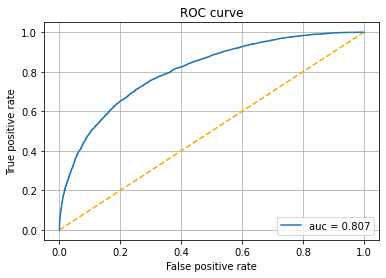

In [9]:
# Get predicted probabilities for the positive class
y_scores = gbt.predict_proba(x_test)[:, 1]

#make ROC curve
drawROC2(y_scores, y_test)

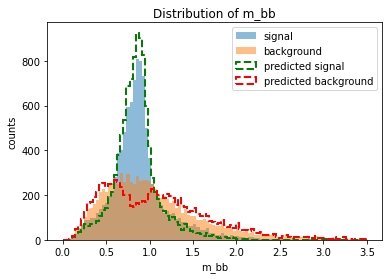

In [10]:
#plot signal vs background with prediction
variable = 'm_bb'
plotSignalvsBgWithPrediction2(x_test.loc[:, variable], y_test, y_pred)

Feature Importance Ranking:
                     Feature  Importance
25                      m_bb    0.159220
26                     m_wbb    0.095197
27                    m_wwbb    0.087621
5                    jet1_pt    0.068382
22                     m_jjj    0.068179
24                     m_jlv    0.058946
8                 jet1_b-tag    0.052134
3   missing_energy_magnitude    0.037450
21                      m_jj    0.036863
0                  lepton_pT    0.034664
9                    jet2_pt    0.031197
16                jet3_b-tag    0.025195
20                jet4_b-tag    0.021892
23                      m_lv    0.021795
13                   jet3_pt    0.021421
17                   jet4_pt    0.020732
12                jet2_b-tag    0.020010
6                   jet1_eta    0.015013
1                 lepton_eta    0.014815
10                  jet2_eta    0.013962
14                  jet3_eta    0.013611
18                   je4_eta    0.012752
11                  jet2_phi 

<Figure size 720x432 with 0 Axes>

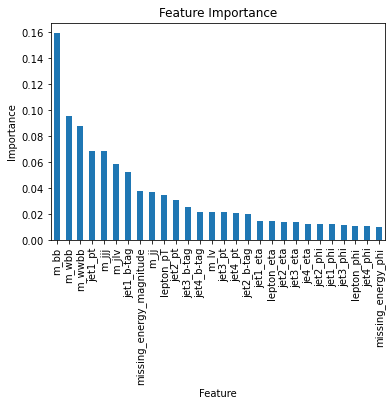

In [11]:
#draw feature importance
drawFeatures(x, gbt)

# Hyperparameter scan

In [12]:
# Get the default hyperparameters
default_params = gbt.get_params()

# Print the default hyperparameters
for param, value in default_params.items():
    print(f"{param}: {value}")

objective: binary:logistic
base_score: None
booster: None
callbacks: None
colsample_bylevel: None
colsample_bynode: None
colsample_bytree: None
device: None
early_stopping_rounds: None
enable_categorical: False
eval_metric: None
feature_types: None
gamma: None
grow_policy: None
importance_type: None
interaction_constraints: None
learning_rate: 0.1
max_bin: None
max_cat_threshold: None
max_cat_to_onehot: None
max_delta_step: None
max_depth: 6
max_leaves: None
min_child_weight: None
missing: nan
monotone_constraints: None
multi_strategy: None
n_estimators: 100
n_jobs: -1
num_parallel_tree: None
random_state: None
reg_alpha: None
reg_lambda: None
sampling_method: None
scale_pos_weight: None
subsample: None
tree_method: None
validate_parameters: None
verbosity: 1


## Exercise 2

- do hyperparameter optimisation on 100k evts using Randomized Grid search
- select a reasonable number and range of hyperparameters
- USE all possible cores (check sklearn doc)
- while the code runs, check with top that there are indeed several python processes running
- check metrics (accuracy, ROC curve, signal vs background, feature ranking)

In [13]:
from sklearn.model_selection import RandomizedSearchCV

# Initialize the model
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric="mlogloss")

# Define the parameter distribution
param_dist = {
    'n_estimators': [50, 100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
    'max_depth': [3, 5, 7, 10],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# Set up RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_dist, n_iter=20, scoring='accuracy', cv=3, n_jobs=-1, verbose=1, random_state=42)

# Run random search
%time random_search.fit(x_train, y_train)

# Best parameters and best score
print("Best parameters found: ", random_search.best_params_)
print("Best accuracy: ", random_search.best_score_)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


/home/jovyan/.local/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [22:04:16] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


CPU times: user 2min 35s, sys: 3.45 s, total: 2min 38s
Wall time: 25.3 s
Best parameters found:  {'subsample': 0.8, 'n_estimators': 100, 'max_depth': 10, 'learning_rate': 0.05, 'colsample_bytree': 0.8}
Best accuracy:  0.7226965342450207


In [14]:
# Evaluate the best model on the test set
best_model = random_search.best_estimator_
y_pred = best_model.predict(x_test)

In [15]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='binary')  # For binary classification
recall = recall_score(y_test, y_pred, average='binary')
f1 = f1_score(y_test, y_pred, average='binary')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

Accuracy: 0.7313
Precision: 0.7453
Recall: 0.7522
F1-Score: 0.7487


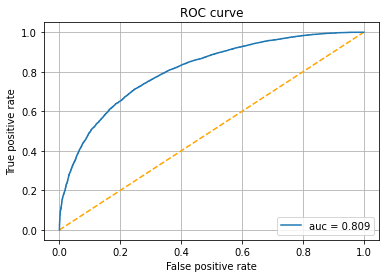

In [16]:
# Get predicted probabilities for the positive class
y_scores = best_model.predict_proba(x_test)[:, 1]

#make ROC curve
drawROC2(y_scores, y_test)

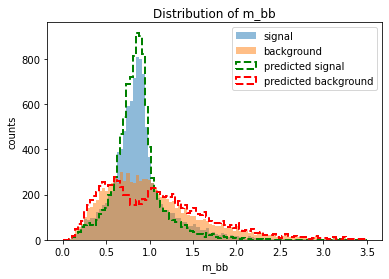

In [17]:
#plot signal vs background with prediction
variable = 'm_bb'
plotSignalvsBgWithPrediction2(x_test.loc[:, variable], y_test, y_pred)

In [18]:
# read in input parquet file
input_file = "Higgs1M.parquet"
%time df = pd.read_parquet(input_file)

#create train/test set
y = df.iloc[:, 0] #df with label
x = df.iloc[: , 1:] #df with all other variables

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
len(y)

CPU times: user 819 ms, sys: 1.05 s, total: 1.87 s
Wall time: 183 ms


999999

In [19]:
# Define the XGBoost classifier with multi-core support
best_gbt = xgb.XGBClassifier(
    n_estimators=100,      # Number of trees 
    max_depth=10,           # Maximum depth of each tree 
    learning_rate=0.05,     # Learning rate
    subsample=0.8,
    colsample_bytree=0.8,
    n_jobs=-1,             # Use all available cores
    verbosity=1            # Set verbosity level to monitor training progress
)

# Train the model
%time best_gbt.fit(x_train, y_train)

# Make predictions on the test set
y_pred = best_gbt.predict(x_test)

CPU times: user 5min 50s, sys: 1.34 s, total: 5min 51s
Wall time: 7.82 s


In [20]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='binary')  # For binary classification
recall = recall_score(y_test, y_pred, average='binary')
f1 = f1_score(y_test, y_pred, average='binary')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

Accuracy: 0.7400
Precision: 0.7505
Recall: 0.7607
F1-Score: 0.7556


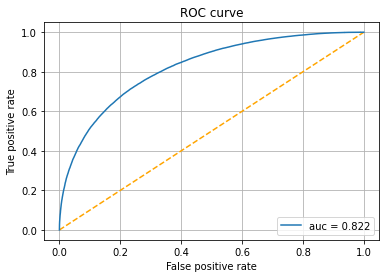

In [21]:
# Get predicted probabilities for the positive class
y_scores = best_gbt.predict_proba(x_test)[:, 1]

#make ROC curve
drawROC2(y_scores, y_test)

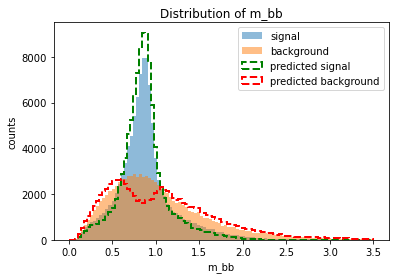

In [22]:
#plot signal vs background with prediction
variable = 'm_bb'
plotSignalvsBgWithPrediction2(x_test.loc[:, variable], y_test, y_pred)

Feature Importance Ranking:
                     Feature  Importance
25                      m_bb    0.203095
27                    m_wwbb    0.097946
26                     m_wbb    0.083720
22                     m_jjj    0.071366
5                    jet1_pt    0.060950
24                     m_jlv    0.059687
8                 jet1_b-tag    0.040658
21                      m_jj    0.038327
0                  lepton_pT    0.036539
3   missing_energy_magnitude    0.034403
9                    jet2_pt    0.028985
12                jet2_b-tag    0.026940
20                jet4_b-tag    0.025097
16                jet3_b-tag    0.023119
23                      m_lv    0.020954
13                   jet3_pt    0.019196
17                   jet4_pt    0.017856
1                 lepton_eta    0.013451
6                   jet1_eta    0.013111
14                  jet3_eta    0.010954
10                  jet2_eta    0.010909
18                   je4_eta    0.010636
15                  jet3_phi 

<Figure size 720x432 with 0 Axes>

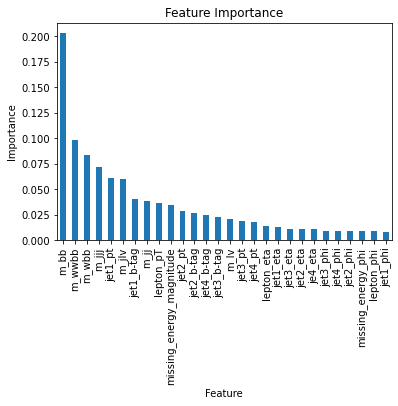

In [23]:
#draw feature importance
drawFeatures(x, best_gbt)